In [91]:
import jax
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun

#### Stochastic interpolants example (SDE)

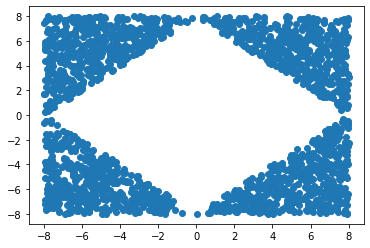

In [2]:
num_target = 2000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 8 * target_samples[jnp.sum(jnp.abs(target_samples),1)>1.][:num_target]

plt.scatter(target_samples[:,0],target_samples[:,1])

In [3]:
num_reference = 2000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))

In [34]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(3, 512, key=key1),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 512, key=key2),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 2, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return jnp.cos(t)*x + jnp.sin(t)*y

def It(t,x,y):
    return -jnp.sin(t)*x + jnp.cos(t)*y

def gamma(t):
    return jnp.sqrt(2*t*(1-t))

gammadot = vmap(vmap(grad(gamma)))

#CHANGE SHIT HERE!!!!!!!!! WARNING!!!!!!!!

@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(b_model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    bhat = jax.vmap(b_model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gammadot(t)*z)*bhat,axis=1))
#     dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - 2*dot_term
    # return jnp.mean((bhat - (It(t,x,y) + gammadot(t)*z))**2)

def loss_denoise(eta_model,t,x,y,z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    etahat = jax.vmap(eta_model)(tx)  # vectorise the model over a batch of data
    
    etanorm2 = jnp.mean(jnp.sum(etahat**2,axis=1))
    dot_term = jnp.mean(jnp.sum(etahat*z,axis=1))
    return etanorm2 - 2*dot_term

In [35]:
t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
model = NeuralNetwork(jax.random.PRNGKey(0))
loss(model,t,reference_samples,target_samples,z)
loss_denoise(model,t,reference_samples,target_samples,z)

Array(1.8619679, dtype=float32)

In [36]:
def evaluate_b(b_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(b_model,t,x,y,z)
    return avg_loss / 100

In [37]:
def evaluate_eta(eta_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss_denoise(eta_model,t,x,y,z)
    return avg_loss / 100

In [38]:
def get_trainloader(batch_size = 128):
    for i in range(10**6):
        trainloader_key = jax.random.PRNGKey(i)
        ref_key,target_key,normal_key,t_key = jax.random.split(trainloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)

        yield t_vals,ref_batch,target_batch,z

def get_testloader(batch_size = 1000):
    num_batches = 100
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield t_vals,ref_batch,target_batch,z

In [39]:
def train_b(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_b(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

In [40]:
def train_eta(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss_denoise)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_eta(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

# DO NOT RUN THIS CELL UNLESS YOU WANNA WAIT FOREVER!

In [126]:
b_learning_rate = 1e-4

b_optim = optax.chain(
   optax.clip_by_global_norm(1.0),
   optax.adamw(b_learning_rate),
)
b_model = NeuralNetwork(jax.random.PRNGKey(420))
b_trainloader = get_trainloader(batch_size = 2048)

b_model,b_losses = train_b(b_model,b_optim,steps=5000,train_loader=b_trainloader,print_every=1000)

step=0 | train_loss=0.6085745 | test_loss= -1.0390834
step=1000 | train_loss=-30.670994 | test_loss= -31.812271
step=2000 | train_loss=-30.30257 | test_loss= -31.961323
step=3000 | train_loss=-31.914118 | test_loss= -31.994873
step=4000 | train_loss=-32.153473 | test_loss= -32.0713
step=4999 | train_loss=-31.002008 | test_loss= -32.079987


In [128]:
eta_learning_rate = 1e-4
eta_trainloader = get_trainloader(batch_size = 2048)

eta_optim = optax.chain(
   optax.clip_by_global_norm(1.0),
   optax.adamw(eta_learning_rate),
)

eta_model = NeuralNetwork(jax.random.PRNGKey(420))
eta_model,eta_losses = train_eta(eta_model,eta_optim,steps=5000,train_loader=eta_trainloader,print_every=1000)

step=0 | train_loss=1.8833121 | test_loss= 1.3842098
step=1000 | train_loss=-0.29790556 | test_loss= -0.24470861
step=2000 | train_loss=-0.22661006 | test_loss= -0.24956715
step=3000 | train_loss=-0.2617684 | test_loss= -0.24766801
step=4000 | train_loss=-0.2344414 | test_loss= -0.25476092
step=4999 | train_loss=-0.22910199 | test_loss= -0.2513444


In [129]:
eps = 0.2
epsilon = lambda t: t*(1-t)*eps 

vmapped_b_model = vmap(b_model)
vmapped_eta_model = vmap(eta_model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x])) - (epsilon(t)/(gamma(t)+1e-12))*vmapped_eta_model(jnp.hstack([t_vec,x]))



t0, t1 = 0.0, 1.0
# t_vec = jnp.ones((len(x),1))*t
# drift = lambda t, x, args: dX_t(t,x)
diffusion = lambda t, x, args: 2*jnp.sqrt(2*epsilon(t))
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jax.random.PRNGKey(1))
terms = MultiTerm(ODETerm(dX_t), ControlTerm(diffusion, brownian_motion))
solver = Heun()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.005, y0=reference_samples.copy(), saveat=saveat)
X = sol.evaluate(1.0)
print(X)  

[[-2.8660762  4.7859974]
 [ 6.393962  -4.0649433]
 [-4.683954  -5.089959 ]
 ...
 [ 5.408862   3.0075703]
 [ 3.586568   5.8131175]
 [ 3.5820158  5.4099274]]


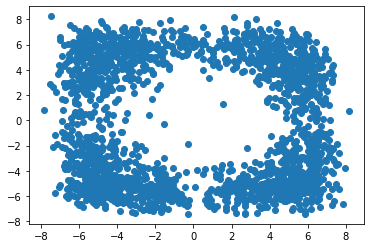

In [130]:
plt.scatter(X[:,0],X[:,1])

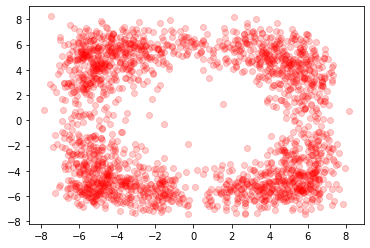

In [131]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)

# Make pretty flow plots later

In [120]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(500):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1],c='blue',alpha = 0.05,lw = 5)

NameError: name 'X_hist' is not defined

In [ ]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=1., dt0=0.01, y0=X0)